In [3]:
from DLtools.Trial_evaluation_rec import record_list_result
from DLtools.Data import instant_data,station_sel
from DLtools.feature_sel import call_mar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import pywt
np.random.seed(42)

In [4]:
############# Keras ###################
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [5]:
##--------------------------- SETTING AREA ------------------------------##
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'
if mode =='hour': n_past,n_future = 24*7,72
elif mode =='day': n_past,n_future = 60,30
st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)

In [6]:
#------------ DL PARAMETER ---------------------#
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-5 * 0.90 ** x)
callbacks = [callback_early_stopping,reduce_lr]
my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)

In [7]:
#--------------------------- 2 Yr Edit -----------------------------------#
host_path = './CPY012/2Yr_flood/'
start_p = '2016-01-01'
split_date = '2017-05-10'
stop_p = '2018-01-01'
n_pca = 7

In [8]:
#-----------------------Baseline / Hybrid -----------------------------------#
save_path =host_path+'trial'
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [9]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
def split_xy(data,n_past,n_future):
    x,y = split_series(data.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],n_features))
    y = y[:,:,0]
    return x,y

In [12]:
# ##--------------added Wavelet ---------------##
# def SWT_seq_tran(signal2d):
#     N,M = np.zeros(signal2d.shape),np.zeros(signal2d.shape)
#     N[:,:],M[:,:] = signal2d[:,:],signal2d[:,:]
#     P[:,:],Q[:,:] = signal2d[:,:],signal2d[:,:]
#     R[:,:],S[:,:] = signal2d[:,:],signal2d[:,:]
#     for i in range(signal2d.shape[1]):
#         coeff = pywt.swt(signal2d[:,i],wavelet='db4',level=3) 
#         # coeff = pywt.dwt(past[:,i],wavelet='db4') #NOTE: exp2 change to dwt
#         cA, cD =coeff[0][0],coeff[0][1]
#         N[:,i] =  cA
#         M[:,i] =  cD
#         #---------------------
#         cA, cD =coeff[1][0],coeff[1][1]
#         P[:,i] =  cA
#         Q[:,i] =  cD
#         #-------------------
#         cA, cD =coeff[2][0],coeff[2][1]
#         R[:,i] =  cA
#         S[:,i] =  cD
#     return N,M,P,Q,S

# def SWTsplit_series_cAcD(series, n_past, n_future):
#     # n_past ==> no of past observations
#     # n_future ==> no of future observations
#     cAx,cDx, cAy,cDy = list(), list(), list(), list()
#     for window_start in range(len(series)):
#         past_end = window_start + n_past
#         future_end = past_end + n_future
#         if future_end > len(series):
#             break
#         # slicing the past and future parts of the window
#         past, future = series[window_start:past_end, :], series[past_end:future_end, :]
#         ######################## Wavelet #########################
#         _cA1,_cD1,_cA2,_cD2,_cA3,_cD3 = SWT_seq_tran(past)
#         cA1_,cD1_,cA2_,cD2_,cA3_,cD3_ = SWT_seq_tran(future)

#         cAx1.append(_cA1);cDx1.append(_cD1);cAx2.append(_cA2);cDx2.append(_cD2);cAx3.append(_cD3);cDx3.append(_cD3)
#         cAy1.append(cA1_);cDy1.append(cD1_);cAy2.append(cA2_);cDy2.append(cD2_);cAy3.append(cA3_);cDy3.append(cD3_)

#     return np.array(cAx1),np.array(cDx1), np.array(cAy1),np.array(cDy1),np.array(cAx1),np.array(cDx1)np.array(cAy), np.array(cDy),np.array(cAx1),np.array(cDx1)np.array(cAy), np.array(cDy)
# def SWTsplit_xy(data,n_past,n_future):
#     cAx,cDx,cAy,cDy = SWTsplit_series_cAcD(data.values,n_past,n_future)
#     cAx = cAx.reshape((cAx.shape[0], cAx.shape[1],n_features))
#     cDx = cDx.reshape((cDx.shape[0], cDx.shape[1],n_features))
    
#     cAy= cAy[:,:,0]
#     cDy= cDy[:,:,0]
#     return cAx,cDx,cAy,cDy

In [67]:
# ##--------------added Wavelet dwt Array ---------------##
# # coeffs = pywt.wavedecn(d_test[:92], wavelet='db')
# # arr, coeff_slices = pywt.coeffs_to_array(coeffs)
# # coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices,output_format='wavedecn')
# # cam_recon = pywt.waverecn(coeffs_from_arr, wavelet='db2')
# #Wave  Split XY
# def DWT_seq_tran(signal2d):
#     N,M = np.zeros(signal2d.shape),np.zeros(signal2d.shape)
#     N[:,:] = signal2d[:,:]
#     for i in range(signal2d.shape[1]):
#         coeff = pywt.wavedecn(signal2d[:,i],wavelet='db4') 
#         arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
#         # coeff = pywt.dwt(past[:,i],wavelet='db4') #NOTE: exp2 change to dwt
#         N[:,i] =  arr
#     return N,coeff_slices, coeff_shapes

# # def call_dwt(singal):
# #     coeffs = pywt.wavedecn(singal, wavelet='db4')
# #     arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
# #     return arr, coeff_slices, coeff_shapes

# def dwt_split_series(series, n_past, n_future):
#     # n_past ==> no of past observations
#     # n_future ==> no of future observations 
#     X, y = list(), list()
#     for window_start in range(len(series)):
#         past_end = window_start + n_past
#         future_end = past_end + n_future
#         if future_end > len(series):
#             break
#         # slicing the past and future parts of the window
#         past, future = series[window_start:past_end, :], series[past_end:future_end, :]
#         cx,_,_ = DWT_seq_tran(past)
#         cy,_,_ = DWT_seq_tran(future)

#         X.append(cx)
#         y.append(cy)
#     return np.array(X), np.array(y)

# def dwt_split_xy(data,n_past,n_future):
#     x,y = dwt_split_series(data.values,n_past,n_future)
#     x = x.reshape((x.shape[0], x.shape[1],n_features))
#     y = y[:,:,0]
#     return x,y


In [14]:
#------------------------- Main ---------------------------------#
df = df[start_p:stop_p]
data = df
data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)

cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

In [15]:
##----------- SCALE
def Preprocess_pca(input):
    
    pipe = Pipeline([('scaler', StandardScaler())])#, ('pca',PCA(n_components =n_pca))])
    scaler = pipe.fit(input)
    sc_input = pipe.transform(input)
    sc_input = pd.DataFrame(sc_input, index=input.index)
    return scaler,sc_input

# X data
_,sc_data = Preprocess_pca(data_mar)
# Y data
scaler_tar = MinMaxScaler()
scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
data_mar[target] = scaler_tar.transform(data_mar[target].to_numpy().reshape(-1,1))


In [16]:
##--- train test split 
sc_train,sc_test = sc_data[:split_date],sc_data[split_date:]
train,test = data_mar[:split_date],data_mar[split_date:]

##--------- Keep original
_, y_train = split_xy(train,n_past,n_future)
_, y_test = split_xy(test,n_past,n_future)
##--------- Wavelet_traintest
# n_features=n_pca
cAxTrain,cDxTrain,cAyTrain,cDyTrain = SWTsplit_xy(sc_train,n_past,n_future)
cAxTest,cDxTest,cAyTest,cDyTest = SWTsplit_xy(sc_test,n_past,n_future)


NameError: name 'SWTsplit_xy' is not defined

In [19]:
#----------------- minmax scale for Deeplearning 
def flatten(X):
    '''
    Flatten a 3D array.
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.   
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)
def scale(X, scaler):
    '''
    Scale 3D array.
    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])                    
    return X
# scaler = MinMaxScaler().fit(flatten(cAxTrain))
# cAX_train = scale(cAxTrain, scaler)
# scaler = MinMaxScaler().fit(flatten(cDxTrain))
# cDX_train = scale(cDxTrain, scaler)
# scaler = MinMaxScaler().fit(flatten(cAxTest))
# cAX_test = scale(cAxTest, scaler)
# scaler = MinMaxScaler().fit(flatten(cDxTest))
# cDX_test = scale(cDxTest, scaler)


In [20]:
# cX_train = [cAxTrain,cDxTrain]
# cX_test = [cAxTest,cDxTest]
# cy_train = [cAyTrain,cDyTrain]
# cy_test = [cAyTest,cDyTest]

# Wavelet Trial

In [167]:
trial_d = data.iloc[100:200,10:12]
trial_d
# trial_d.head()

,BKK020_wl,BKK021_wl
date,,
2016-01-05 04:00:00,-0.157878,1.040000
2016-01-05 05:00:00,-0.157935,1.040000
2016-01-05 06:00:00,-0.157993,1.040000
2016-01-05 07:00:00,-0.158051,1.038333
2016-01-05 08:00:00,-0.158108,1.040000
...,...,...
2016-01-09 03:00:00,-0.163356,1.026667
2016-01-09 04:00:00,-0.163414,1.020000
2016-01-09 05:00:00,-0.163472,1.020000


In [168]:
def DWT_seq_tran(signal2d):
    lv = 2
    N = np.zeros((signal2d.shape[0],signal2d.shape[1]*lv))
    for i in range(signal2d.shape[1]):
        arr = pywt.swt(signal2d[:,i],wavelet='db4',level=lv-1)
        cA,cD = arr[0][0],arr[0][1]#,arr[1][1]
        N[:,i+0] = cA
        N[:,i+1] = cD
    return N

X, y = list(), list()
t_past = 30
t_future = 1
series=trial_d.values
for window_start in range(len(series)):
    past_end = window_start + t_past
    future_end = past_end + t_future
    print(window_start)
    if future_end > len(series):
        break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    # print(past,'**', future)
    print('#',"-"*20,'#')
    past = DWT_seq_tran(past)
    # future = DWT_seq_tran(future)
    print(past,'**', future)
    print('#',"*"*20,'#')
    X.append(past)
    y.append(future)
X,y = np.array(X),np.array(y)

0000000e+00]
 [-2.29145452e-01  1.44722462e+00  1.86280068e-03  0.00000000e+00]
 [-2.29226992e-01  1.44251525e+00  3.75268888e-03  0.00000000e+00]
 [-2.29308560e-01  1.44323766e+00 -4.12575062e-03  0.00000000e+00]
 [-2.29390115e-01  1.44876742e+00 -2.74443906e-03  0.00000000e+00]
 [-2.29471669e-01  1.46481574e+00  3.16635706e-03  0.00000000e+00]
 [-2.29553252e-01  1.48828685e+00 -2.29996629e-04  0.00000000e+00]
 [-2.29634807e-01  1.50480151e+00 -4.54501249e-04  0.00000000e+00]
 [-2.29716361e-01  1.51265407e+00 -3.44968773e-03  0.00000000e+00]
 [-2.29797900e-01  1.52045798e+00  6.11348450e-03  0.00000000e+00]
 [-2.29879469e-01  1.52699518e+00 -2.51636375e-03  0.00000000e+00]
 [-2.29961023e-01  1.52605736e+00 -1.93715096e-03  0.00000000e+00]
 [-2.30042562e-01  1.52266908e+00  1.49988383e-03  0.00000000e+00]
 [-2.30142489e-01  1.52374434e+00  1.11792237e-03  0.00000000e+00]
 [-2.30167150e-01  1.52317309e+00 -1.45271886e-03  0.00000000e+00]
 [-2.30195343e-01  1.51784372e+00  8.35895538e-04

(70, 30, 4)


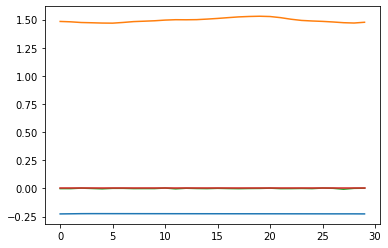

In [180]:
print(X.shape)
plt.plot(X[0,:,:])
# plt.plot(N[:,i])

# plt.plot(X[0,:,1])

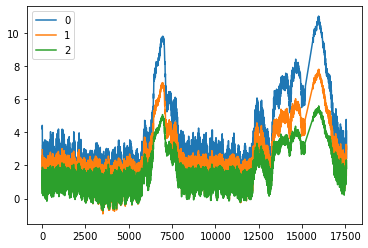

In [21]:
coeff = pywt.swt(data[target],wavelet='db4',level=3) 
for i in range(3):
    plt.plot(coeff[i][0],label=i)
plt.legend()
# for i in range(3):
#     plt.plot(coeff[i][1],label=i)
# plt.legend()

# Wavelet transform Trial 2

In [187]:
data_mar[target].name 

'CPY012_wl'

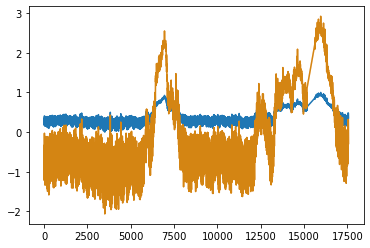

In [243]:
X = series.values
X = (X - X.mean())/(X.std())
std = StandardScaler().fit_transform(series.values.reshape(-1,1))

plt.plot(series.values)
plt.plot(X)
plt.plot(std,alpha=0.2)

In [263]:
#-------------------
std_scale=False
#==================
series = data_mar[target]
name = series.name
idx = series.index
signal = series.values
if std_scale: signal = (signal - signal.mean())/(signal.std())

coeff = pywt.swt(signal,'db4',level=3)
coeff = np.array(coeff)

cA3,cD3 = coeff[0][0],coeff[0][1]
cA2,cD2 = coeff[1][0],coeff[1][1]
cA1,cD1 = coeff[2][0],coeff[2][1]
# coeff.shape

In [264]:
dict_data = {'{}_cA3'.format(name): cA3,
            '{}_cD3'.format(name): cD3,
            '{}_cD2'.format(name): cD2,
            '{}_cD1'.format(name): cD1}
wt = pd.DataFrame(dict_data,dtype='float32',index=idx)

<AxesSubplot:xlabel='date'>

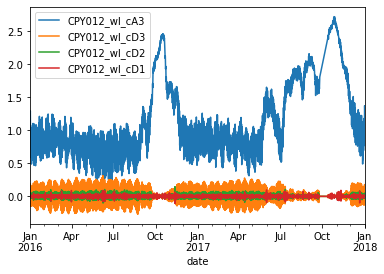

In [265]:
wt.plot()

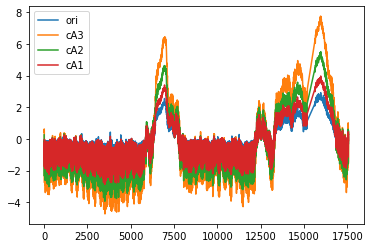

In [246]:
plt.plot(series,label='ori')
plt.plot(cA3,label='cA3')
# plt.plot(cD3,label='cD3')
plt.plot(cA2,label='cA2')
# plt.plot(cD2,label='cD2')
plt.plot(cA1,label='cA1')
# plt.plot(cD1,label='cD1')

plt.legend()

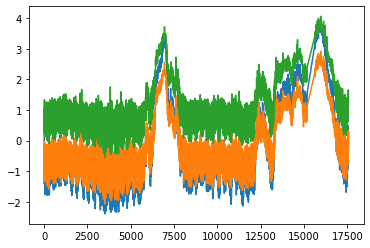

In [251]:
iwave = pywt.iswt((cA3,cD2,cD1),'db4')
iwave2 = pywt.iswt((cA3,cD3,cD2,cD1),'db4')
plt.plot(iwave)
plt.plot(iwave2)
plt.plot(data[target].values)
# plt.plot(series)

In [282]:
def wavelet_t(series,std):
    name = series.name
    idx = series.index
    signal = series.values
    if std: signal = (signal - signal.mean())/(signal.std())

    coeff = pywt.swt(signal,'db4',level=3)
    coeff = np.array(coeff)

    cA3,cD3 = coeff[0][0],coeff[0][1]
    _,cD2 = coeff[1][0],coeff[1][1]
    _,cD1 = coeff[2][0],coeff[2][1]
    #----------------------------
    dict_data = {
            '{}_cA3'.format(name): cA3,
            '{}_cD3'.format(name): cD3,
            '{}_cD2'.format(name): cD2,
            '{}_cD1'.format(name): cD1}
    wt = pd.DataFrame(dict_data,dtype='float32',index=idx)
    return wt
def df_wavelet(df,std):
    wav_df = pd.DataFrame()
    for col in df:
        a = wavelet_t(df[col],std)
        wav_df = pd.concat([wav_df,a],axis=1)
    return wav_df
    

In [283]:
data_mar

,CPY012_wl,NAN009_wl,CPY006_wl,PIN004_wl,DNP028_press,WAN003_wl,BKK021_wl,YOM012_wl,WAN005_wl,BKK013_wl
date,,,,,,,,,,
2016-01-01 00:00:00,0.345987,179.360001,3.575000,40.238335,943.219971,171.809998,1.070000,45.633335,231.529999,1.490000
2016-01-01 01:00:00,0.325741,179.360001,3.556667,40.221668,943.219971,171.808334,1.070000,45.619999,231.533340,1.490000
2016-01-01 02:00:00,0.299349,179.360001,3.560000,40.206665,943.219971,171.801666,1.068333,45.610001,231.538330,1.493333
2016-01-01 03:00:00,0.270065,179.360001,3.560000,40.243332,943.219971,171.800003,1.060000,45.598331,231.536667,1.500000
2016-01-01 04:00:00,0.242950,179.360001,3.566667,40.256668,942.140015,171.800003,1.060000,45.588333,231.535004,1.500000
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 19:00:00,0.434563,179.136673,5.957500,41.400002,934.539978,172.014999,1.230000,45.834999,232.053329,2.280000
2018-01-01 20:00:00,0.419740,179.134995,5.957500,41.400002,935.630005,172.011673,1.230000,45.851665,232.051666,2.280000
2018-01-01 21:00:00,0.400217,179.136673,5.957500,41.400002,935.630005,172.009995,1.230000,45.876667,232.054993,2.280000


In [285]:
df_wavelet(data_mar,True)

,CPY012_wl,CPY012_wl_cA3,CPY012_wl_cD3,CPY012_wl_cD2,CPY012_wl_cD1,NAN009_wl,NAN009_wl_cA3,NAN009_wl_cD3,NAN009_wl_cD2,NAN009_wl_cD1,...,WAN005_wl,WAN005_wl_cA3,WAN005_wl_cD3,WAN005_wl_cD2,WAN005_wl_cD1,BKK013_wl,BKK013_wl_cA3,BKK013_wl_cD3,BKK013_wl_cD2,BKK013_wl_cD1
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-0.338632,0.405309,-0.613742,-0.008493,-0.009417,-0.430736,-1.682713,-0.047532,-0.047287,2.198606e-03,...,-1.071699,-1.196433,0.179214,0.165286,-0.009996,-1.080684,0.535972,0.384058,0.350971,-1.179977e-02
2016-01-01 01:00:00,-0.439511,0.508822,-0.481579,-0.007025,0.004052,-0.430736,-1.694562,-0.057573,-0.028299,7.665182e-03,...,-1.067714,-1.170617,0.225529,0.103827,-0.029599,-1.080684,0.622917,0.485776,0.206125,-5.849658e-02
2016-01-01 02:00:00,-0.571014,0.570365,-0.178477,-0.112158,0.004859,-0.430736,-1.710174,-0.059968,-0.005848,1.864956e-03,...,-1.061763,-1.132415,0.236634,0.021370,-0.005767,-1.075253,0.732579,0.509810,0.029765,-1.546428e-02
2016-01-01 03:00:00,-0.716929,0.601300,0.211230,-0.199272,-0.001440,-0.430736,-1.731040,-0.056665,0.003299,-1.862645e-09,...,-1.063747,-1.074259,0.215396,-0.024432,0.003167,-1.064392,0.878515,0.459285,-0.050264,3.734585e-04
2016-01-01 04:00:00,-0.852035,0.618683,0.571331,-0.051142,-0.029113,-0.430736,-1.751061,-0.050678,0.009009,2.910476e-04,...,-1.065730,-1.018185,0.172300,-0.038806,-0.002897,-1.064392,1.015602,0.359122,-0.065450,-2.597777e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 19:00:00,0.102715,-0.778808,0.108167,-0.038280,0.002077,-0.600378,-1.685918,0.145154,0.014330,-3.966428e-03,...,-0.447551,-1.126695,-0.512507,-0.057554,0.002573,0.206321,0.535368,-1.062768,-0.120381,-2.095476e-09
2018-01-01 20:00:00,0.028857,-0.469114,0.035073,0.038174,-0.013281,-0.601653,-1.678113,0.119200,0.109737,-3.902531e-02,...,-0.449535,-1.162680,-0.418275,-0.392568,0.143599,0.206321,0.481517,-0.863681,-0.801437,2.964972e-01
2018-01-01 21:00:00,-0.068419,-0.183854,-0.132050,0.052729,0.029114,-0.600378,-1.670947,0.066815,0.071472,8.636519e-02,...,-0.445568,-1.198904,-0.234390,-0.248263,-0.308334,0.206321,0.432294,-0.482788,-0.515310,-6.235133e-01


<AxesSubplot:xlabel='date'>

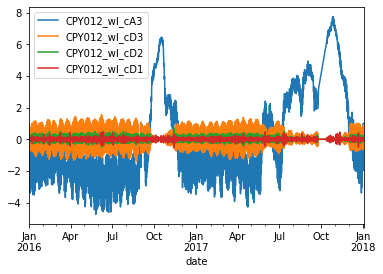

In [269]:
wavelet_t(data[target],True).plot()

# Deep learning

In [35]:
#----------------------------------------------------------#
def build_lstm():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.LSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model
#------------------------------------------------------------#
def build_cnn1d():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer='adam', loss='mse')    
    model.summary()
    return model

In [37]:
model = build_cnn1d()
verbose, epochs = 1, 50
history = model.fit(coffX_train,coffy_train,epochs=epochs,validation_data=(coffX_test,coffy_test),batch_size=32,verbose=verbose,callbacks=callbacks)
trainPredic_cA = model.predict(coffX_train)
testPredict_cA = model.predict(coffX_test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168, 10)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 167, 64)           1344      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 83, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 5312)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5312)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               531300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0     

In [43]:
trainPredic_cA.shape,testPredict_cA.shape

((11665, 72), (5449, 72))

In [59]:
coeffs = pywt.wavedecn(data[target][:-1], wavelet='db2')
arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
coeffs_from_arr = pywt.unravel_coeffs(arr, coeff_slices, coeff_shapes,output_format='wavedecn')
cam_recon = pywt.waverecn(coeffs_from_arr, wavelet='db2')
# coeffs_from_arr = pywt.array_to_coeffs(trainPredic_cA, coeff_slices)
# cam_recon = pywt.waverecn(coeffs_from_arr, wavelet='db2')

In [60]:
cam_recon

array([1.0450002 , 0.9516671 , 0.83000016, ..., 1.2950002 , 1.1966672 ,
       1.1966671 ], dtype=float32)

In [44]:
iwave = list()
for i in range(trainPredic_cA.shape[0]):
    coeff_wave = pywt.iswt(trainPredic_cA[i,:],key_Ytr, output_format='wavedecn')
    iwave = pywt.waverecn(coeff_wave, wavelet='db4')
    iwave.append(wave)
iwave = np.array(iwave)

TypeError: iswt() got an unexpected keyword argument 'output_format'

In [46]:
iwave = list()
for i in range(trainPredic_cA.shape[0]):
    wave = pywt.iswt((trainPredic_cA[i,:],trainPredict_cD[i,:]), 'db4')
    iwave.append(wave)
iwave = np.array(iwave)

In [47]:
iwave.shape

(11665, 72)

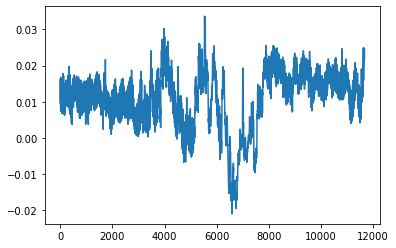

In [50]:
plt.plot(iwave[:,1])